<a href="https://colab.research.google.com/github/hajabikouf/test_notebooks/blob/main/CIFAR_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import datasets as ds
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# choose between mnist or fasion mnist or CIFAR
# Note training using CNN on mnist takes longer but gives better results than the mnist ANN notebook check github
# data = ds.mnist.load_data()
# data = ds.fashion_mnist.load_data()
data = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = data
y_train, y_test = y_train.flatten(), y_test.flatten()
# normalize images
x_train, x_test = x_train / 255.0, x_test / 255.0
print("x_train.shape:", x_train.shape)

170500096/170498071 [==============================] - 2s 0us/step
x_train.shape: (50000, 32, 32, 3)


In [3]:
# only run this when he have grey scale images to give them a channel dimension
# the data is only 2D!
# convolution expects height x width x color

# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)
# print(x_train.shape)

In [4]:
# number of classes
K = len(set(y_train))
print("number of classes:", K)

number of classes: 10


# This paper shows that we can replace conv-pooling with strided conv with out a loss in accuracy  
###. https://arxiv.org/pdf/1412.6806.pdf


#### note! : using strided conv makes training faster since less features are being learned withouth a neglegable performance decrease/increase.



In [5]:
tf.keras.backend.clear_session()
# Build the model using the functional API
i = Input(shape=x_train[0].shape)
# x = Conv2D(32, (3, 3), strides=2, activation='relu')(i)
# x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)
# x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)

# x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
# x = BatchNormalization()(x)
# x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)
# x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
# x = BatchNormalization()(x)
# x = MaxPooling2D((2, 2))(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), strides=2, activation='relu')(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), strides=2, activation='relu')(x)


# x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(K, activation='softmax')(x)

model = Model(i, x)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          18496 

In [6]:
#  Note: make sure you are using the GPU for this!
# here we will also try data augmentation to see results on 50 epochs without data augmentation the resutls were -> 1.0042 - accuracy: 0.7869
# with data augminaiton the results were loss: 0.4649 - accuracy: 0.8521 with strided conv instead of pooling
datagen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(x_train)
# fits the model on batches with real-time data augmentation:
r = model.fit(datagen.flow(x_train, y_train, batch_size=32),validation_data=(x_test, y_test), steps_per_epoch=len(x_train) / 32, epochs=50)


# r = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=50)

Epoch 1/50
1562/1562 [==============================] - 58s 33ms/step - loss: 1.6961 - accuracy: 0.3662 - val_loss: 1.1910 - val_accuracy: 0.5612
Epoch 2/50
1562/1562 [==============================] - 48s 31ms/step - loss: 1.1884 - accuracy: 0.5702 - val_loss: 1.1146 - val_accuracy: 0.6023
Epoch 3/50
1562/1562 [==============================] - 47s 30ms/step - loss: 1.0352 - accuracy: 0.6320 - val_loss: 1.0819 - val_accuracy: 0.6316
Epoch 4/50
1562/1562 [==============================] - 49s 31ms/step - loss: 0.9285 - accuracy: 0.6729 - val_loss: 1.1182 - val_accuracy: 0.6370
Epoch 5/50
1562/1562 [==============================] - 49s 32ms/step - loss: 0.8580 - accuracy: 0.7006 - val_loss: 0.8896 - val_accuracy: 0.6980
Epoch 6/50
1562/1562 [==============================] - 27s 18ms/step - loss: 0.8045 - accuracy: 0.7195 - val_loss: 0.8683 - val_accuracy: 0.6953
Epoch 7/50
1562/1562 [==============================] - 34s 22ms/step - loss: 0.7701 - accuracy: 0.7298 - val_loss: 0.8532 -

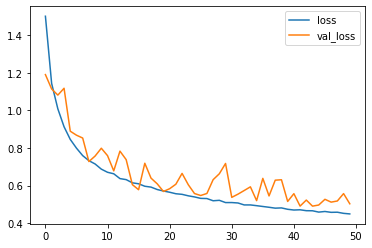

In [7]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

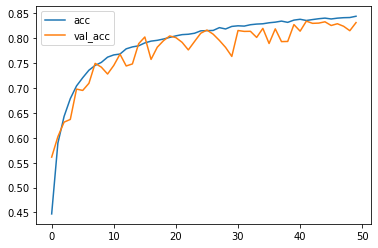

In [8]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [9]:
# Evaluate the model
print(model.evaluate(x_test, y_test))

313/313 [==============================] - 1s 2ms/step - loss: 0.5030 - accuracy: 0.8317
[0.5030284523963928, 0.8317000269889832]


In [10]:
# CIFAR10 labels
labels = '''airplane
automobile
bird
cat
deer
dog
frog
horse
ship
truck'''.split()
"""
# Label mapping for fasion mnist
labels = '''T-shirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot'''.split("\n")
"""
"""# this is used if testing is done on normal mnist
# Label mapping
labels = '''0
1
2
3
4
5
6
7
8
9'''.split("\n")"""

'# this is used if testing is done on normal mnist\n# Label mapping\nlabels = \'\'\'0\n1\n2\n3\n4\n5\n6\n7\n8\n9\'\'\'.split("\n")'

Confusion matrix, without normalization
[[775  15  45  16  18   1  20   9  50  51]
 [  4 916   1   3   0   0   6   2  13  55]
 [ 32   1 716  32  48  31  93  27   6  14]
 [  8   6  30 671  42  94  94  29   9  17]
 [  4   1  34  19 836   7  66  29   2   2]
 [  3   5  22 118  37 700  59  48   2   6]
 [  2   1  10  19   6   6 951   3   2   0]
 [  6   1   8  22  38  10  19 887   2   7]
 [ 22  11   4   2   1   0  13   2 925  20]
 [  4  29   1   4   1   1   3   1  16 940]]


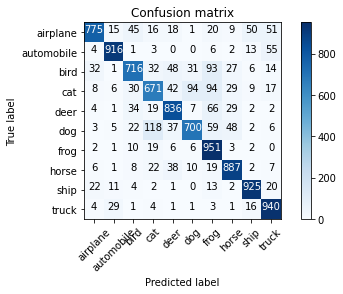

In [11]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = model.predict(x_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, labels)



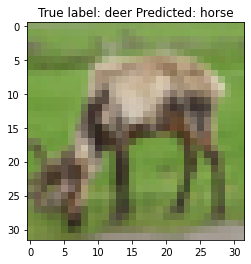

In [12]:
# Show some misclassified examples
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[y_test[i]], labels[p_test[i]]));